# **Instituto de Informática - UFG**

Disciplina: Inteligência Artificial

Prof. Cedric Luiz de Carvalho

Grupo ( A )

---


Aluna(o): Luana Guedes Barros Martins

---

Aluna(o): Ruan Chaves Rodrigues

---

Aluna(o): Thiago Monteles de Souza

---

# Atividade Prática 06 - Processamento de Linguagem Natural

Particionamento das atividades:
- Luana Guedes Barros Martins: Desenvolvedor
- Ruan Chaves Rodrigues: Analista de dados
- Thiago Monteles de Souza: Gerente do Projeto

In [1]:
!pip install gensim

In [2]:
!pip install spacy

In [3]:
!python -m spacy download pt_core_news_sm

✔ Download and installation successful
You can now load the model via spacy.load('pt_core_news_sm')


In [4]:
!pip install nltk
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
# Imports

from collections import defaultdict
from gensim import corpora, models, similarities
from gensim.utils import simple_preprocess
import numpy as np

import pandas as pd
import spacy 
from collections import Counter
import seaborn as sns

%matplotlib inline
import matplotlib.pyplot as plt
import networkx as nx

## Descrição do Problema

Utilizando as técnicas estudadas, será desenvolvido uma ferramenta que permita a comparação de pequenos textos. Devem ser definidas métricas de comparação que classifique os textos segundo critérios de similaridade.

A ferramenta deverá ser aplicada aos Estudos Dirigidos desenvolvidos ao longo do curso de Inteligência Artificial 2019-3. Para cada estudo, deve-se construir uma matriz que mostre a similaridade entre os documentos. Depois, definir um documento de referência e traçar um gráfico de similaridade dos demais em relação a ele.

## Tratamento dos Dados

In [6]:


def preprocess(source):
    stopwords = nltk.corpus.stopwords.words('portuguese')
    nlp = spacy.load("pt_core_news_sm")
    docs = pd.read_csv(source, sep=";").fillna('o').astype(str).values.flatten().tolist()
    ids = pd.read_csv(source, sep=";").fillna('o').values
    ids = [ [(idx2, idx) for idx,v in enumerate(v2) ] for idx2,v2 in enumerate(ids) ]
    ids = [x for y in ids for x in y ]
    docs = [nlp(x) for x in docs]
    docs = [ [ y for y in x if y.is_punct == False and y.text.lower() not in stopwords] for x in docs ]
    tokens = [ [ y.lemma_.lower() for y in x ] for x in docs ]
    
    counter = dict(Counter([ x for y in tokens for x in y ]))
    low_freq = [x for x in counter.keys() if counter[x] == 1]
    tokens = [ [ x for x in y if x not in low_freq ] for y in tokens ]
    
    token_docs = [ ' '.join(x) for x in tokens ]
    mydict = corpora.Dictionary([simple_preprocess(line) for line in token_docs])
    
    corpus = [mydict.doc2bow(simple_preprocess(line)) for line in token_docs]
    
    return {
        "nlp": docs,
        "corpus" : corpus,
        "dict": mydict,
        "tokens": tokens,
        "ids" : ids
    }

## Definição do Modelo

In [7]:
def tfidf(preprocess_dict):
    corpus = preprocess_dict['corpus']
    mydict = preprocess_dict['dict']
    nf = len(mydict.dfs)
    tfidf = models.TfidfModel(corpus)
    index = similarities.SparseMatrixSimilarity(tfidf[corpus], num_features=nf)
    return {
        "model" : tfidf,
        "index" : index
    }

def get_dataplot(preprocess_dict, model_dict):
    corpus = preprocess_dict['corpus']
    tfidf = model_dict['model']
    index = model_dict['index']
    dataplot = []
    for item in corpus:
        dataplot.append(index[tfidf[item]])
    return pd.DataFrame(dataplot)

def get_dict(preprocess_dict=None, dataplot=None, threshold=None):
    ids = preprocess_dict['ids']
    df = dataplot
    tmp = df.applymap(lambda x: 'nan' if x < threshold else x)
    arr = tmp.values.tolist()
    matches = []
    
    for idx, item in enumerate(arr):
        for idx2, item2 in enumerate(item):
            if idx != idx2 and arr[idx][idx2] != 'nan':
                matches.append([idx, idx2])
    pairs = [ [ ids[x][0] for x in y ] for y in matches ]
    
    dict_pairs = dict(Counter([ tuple(x) for x in pairs ])).items()
    
    max_val = max([ x[0][0] for x in dict_pairs ])
    dataplot = []
    for i in range(max_val):
        row = []
        for j in range(max_val):
            if i != j:
                for item in dict_pairs:
                    if i == item[0][0] and j == item[0][1]:
                        row.append(item[1])
                        break
                else:
                    row.append(0)
        dataplot.append(row)
    return dataplot

In [8]:
source = "Dados - ED05.csv"

In [9]:
data_dict = preprocess(source)

In [10]:
model_dict = tfidf(data_dict)

In [11]:
plt.rcParams["figure.figsize"] = (20,10)

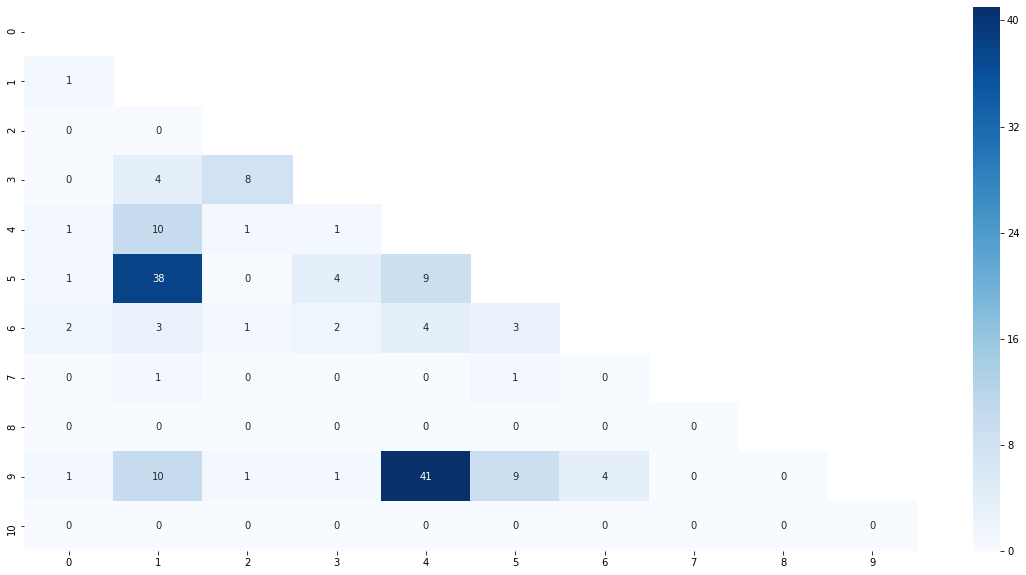

In [12]:
dataplot = get_dict(preprocess_dict=data_dict, 
                    dataplot=get_dataplot(data_dict, model_dict), 
                    threshold=0.9)

mask = np.zeros_like(dataplot, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(data=pd.DataFrame(dataplot), mask=mask, cmap='Blues', annot=True)

In [13]:
pd.set_option('display.max_colwidth', -1)
pd.read_csv(source, sep=";").iloc[[9,4]].transpose().sample(5)

,9,4
Resposta 22,"A principal limitação das redes de uma camada, como as redes perceptron e adaline, é que elas conseguem classificar apenas objetos que são linearmente separáveis.","A principal limitação das redes de uma camada, como as redes perceptron e adaline, é que elas conseguem classificar apenas objetos que são linearmente separáveis."
Resposta 39,"O número de neurônios em uma camada intermediária de uma RNA depende de vários fatores, como: número de exemplos de treinamento; quantidade de ruído presente nos exemplos; complexidade da função a ser aprendida; distribuição estatística dos dados de treinamento.","O número de neurônios em uma camada intermediária de uma RNA depende de vários fatores, como: número de exemplos de treinamento; quantidade de ruído presente nos exemplos; complexidade da função a ser aprendida; distribuição estatística dos dados de treinamento."
Resposta 5,"Apesar de os neurônios biológicos possuírem um tempo de execução normalmente da ordem de 10^(-3) segundos, o cérebro é capaz de realizar diversas tarefas (como reconhecimento de padrões, percepção e controle motor) várias vezes mais rapidamente que o mais rápido computador digital existente na atualidade.","Apesar de os neurônios biológicos possuírem um tempo de execução normalmente da ordem de 10^(-3) segundos, o cérebro é capaz de realizar diversas tarefas (como reconhecimento de padrões, percepção e controle motor) várias vezes mais rapidamente que o mais rápido computador digital existente na atualidade."
Resposta 19,"O teorema de convergência de uma rede perceptron diz que se é possível classificar um conjunto de entradas linearmente, uma rede perceptron fará a classificação.","O teorema de convergência de uma rede perceptron diz que se é possível classificar um conjunto de entradas linearmente, uma rede perceptron fará a classificação."
Resposta 20,"As principais diferenças entre as duas redes é que a rede adaline utiliza uma função de ativação linear e, assim, leva a magnitude do erro em consideração na hora de ajustar os pesos na rede.","As principais diferenças entre as duas redes é que a rede adaline utiliza uma função de ativação linear e, assim, leva a magnitude do erro em consideração na hora de ajustar os pesos na rede."


In [14]:
pd.set_option('display.max_colwidth', -1)
pd.read_csv(source, sep=";").iloc[[5,1]].transpose().sample(5)

,5,1
Resposta 37,"Plotando um gráfico com as taxas de erros dos dados de treinamento e validação e examinando. Quando a taxa de erro de validação começar a subir, significa que a rede parou de aprender.","Plotando um grafico com as taxas de erros dos dados de treinamento e validação e examinando. Quando a taxa de erro de validação começar a subir, significa que a rede parou de aprender."
Resposta 17,"O valor da taxa de aprendizado define a magnitude do ajuste feito no valor de cada peso. Valores altos fazem com que as variações sejam grandes,enquanto taxas pequenas implicam poucas variações nos pesos.","O valor da taxa de aprendizado define a magnitude do ajuste feito no valor de cada peso. Valores altos fazem com que as variações sejam grandes,enquanto taxas pequenas implicam poucas variações nos pesos."
Resposta 7,A arquitetura de uma RNA está relacionada ao tipo e número de unidades de processamento e à forma como os neurônios estão conectados.,A arquitetura de uma RNA está relacionada ao tipo e numero de unidades de processamento e a forma como os neurônios estão conectados.
Resposta 1,"O fundamento natural das redes neurais artificiais é baseado na complexa estrutura biológica dos seres humanos. Especialmente, a redes neurais artificiais foram inspiradas no funcionamento do sistema nervoso, com o objetivo de simular a capacidade de aprendizado do cérebro humano na aquisição de conhecimento.","O fundamento natural das redes neurais artificiais é baseado na complexa estrutura biológica dos seres humanos. Especialmente, a redes neurais artificiais foram inspiradas no funcionamento do sistema nervoso, com o objetivo de simular a capacidade de aprendizado do cérebro humano na aquisição de conhecimento."
Resposta 32,"Como os valores dos erros são conhecidos apenas para os neurônios da camada de saída, o erro para os neurônios das camadas intermediárias precisa estimado. O algoritmo back-propagation propõe uma maneira de estimar o erro dos neurônios das camadas intermediárias utilizando os erros observados nos neurônios da camada anterior. O erro de um neurônio de uma dada camada intermediária é estimado como a soma dos erros dos neurônios da camada seguinte, cujos terminais de entrada estão conectados a ele, ponderados pelo valor do peso associado a essas conexões.","Como os valores dos erros são conhecidos apenas para os neurônios da camada de saída, o erro para os neurônios das camadas intermediárias precisa estimado. O algoritmo back-propagation propõe uma maneira de estimar o erro dos neurônios das camadas intermediárias utilizando os erros observados nos neurônios da camada anterior. O erro de um neurônio de uma dada camada intermediária é estimado como a soma dos erros dos neurônios da camada seguinte, cujos terminais de entrada estão conectados a ele, ponderados pelo valor do peso associado a essas conexões."


In [15]:
source = "Dados - ED08.csv"

In [16]:
data_dict = preprocess(source)
model_dict = tfidf(data_dict)

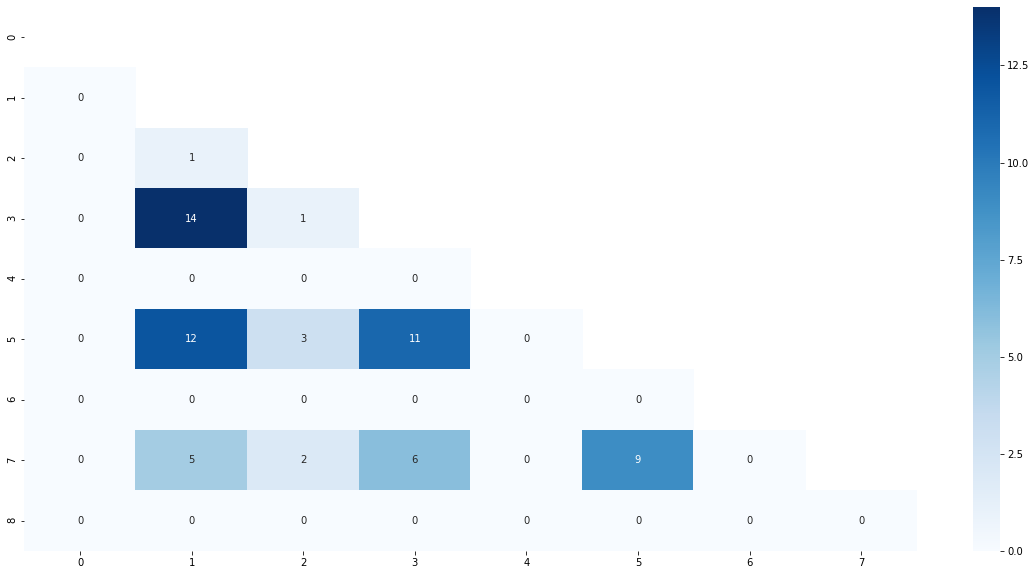

In [17]:
dataplot = get_dict(preprocess_dict=data_dict, 
                    dataplot=get_dataplot(data_dict, model_dict), 
                    threshold=0.9)

mask = np.zeros_like(dataplot, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(data=pd.DataFrame(dataplot), mask=mask, cmap='Blues', annot=True)

In [18]:
source = "Dados- ED09.csv"

In [19]:
data_dict = preprocess(source)
model_dict = tfidf(data_dict)

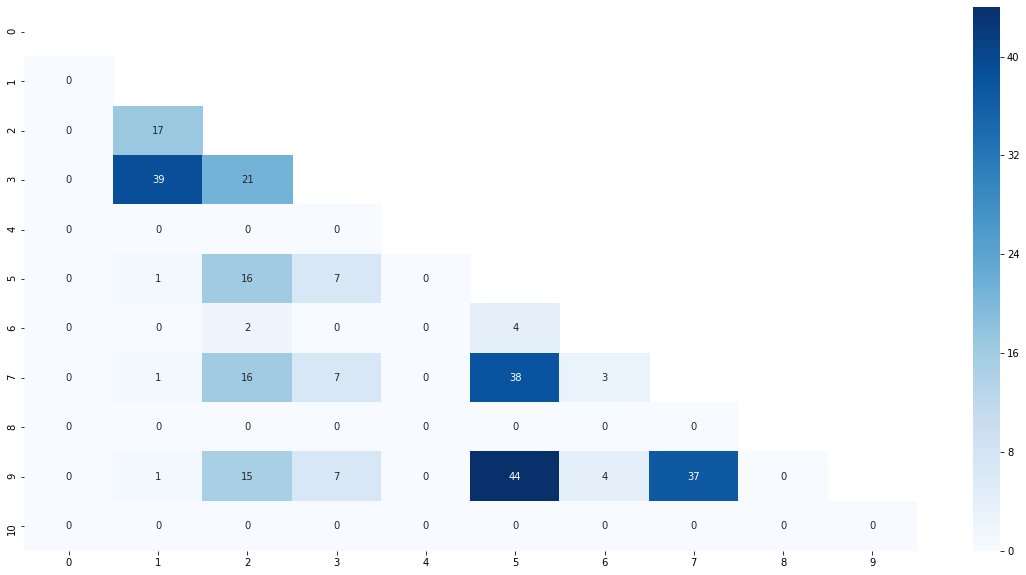

In [20]:
dataplot = get_dict(preprocess_dict=data_dict, 
                    dataplot=get_dataplot(data_dict, model_dict), 
                    threshold=0.9)

mask = np.zeros_like(dataplot, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(data=pd.DataFrame(dataplot), mask=mask, cmap='Blues', annot=True)

In [21]:
pd.set_option('display.max_colwidth', -1)
pd.read_csv(source, sep=";").iloc[[9,5]].transpose().sample(5)

,9,5
Resposta 7,"Isso envolve o exame do significado das palavras e frases. Como veremos, é possível que uma sentença esteja sintaticamente correta, mas sem significado semanticamente. Por outro lado, é desejável que um sistema de computador seja capaz de compreender sentenças com sintaxe incorreta, mas que ainda transmitam informações úteis semanticamente.","Isso envolve o exame do significado das palavras e frases. Como veremos, é possível que uma sentença esteja sintaticamente correta, mas sem significado semanticamente. Por outro lado, é desejável que um sistema de computador seja capaz de compreender sentenças com sintaxe incorreta, mas que ainda transmitam informações úteis semanticamente."
Resposta 37,"O corpus de documentos é claramente muito importante. Como já foi discutido, ambiguidades no texto da consulta podem ser evitadas se o corpus for muito específico. Os sistemas de recuperação de informação tendem a não lidar bem com a ambigüidade porque geralmente não recebem nenhum conhecimento do mundo, mas são simplesmente projetados para executar análises estatísticas de palavras, a fim de identificar respostas adequadas a uma consulta.","O corpus de documentos é claramente muito importante. Como já foi discutido, ambiguidades no texto da consulta podem ser evitadas se o corpus for muito específico. Os sistemas de recuperação de informação tendem a não lidar bem com a ambigüidade porque geralmente não recebem nenhum conhecimento do mundo, mas são simplesmente projetados para executar análises estatísticas de palavras, a fim de identificar respostas adequadas a uma consulta."
Resposta 39,"Stemming é frequentemente aplicado em sistemas de recuperação de informação para evitar este problema. O stemming envolve simplesmente remover hastes comuns como -ing, -s e -ed das palavras. Desta forma, a palavra natação será determinada para nadar e corresponderá a nadadores, nadadores e assim por diante. Normalmente não será capaz de combinar swam ou swum, porque estas são formas irregulares.","Stemming é frequentemente aplicado em sistemas de recuperação de informação para evitar este problema. O stemming envolve simplesmente remover hastes comuns como -ing, -s e -ed das palavras. Desta forma, a palavra natação será determinada para nadar e corresponderá a nadadores, nadadores e assim por diante. Normalmente não será capaz de combinar swam ou swum, porque estas são formas irregulares."
Resposta 9,"Os sistemas de processamento de linguagem natural devem aplicar algum tipo de conhecimento do mundo. Na maioria dos sistemas do mundo real, esse conhecimento mundial é limitado a um domínio específico (por exemplo, um sistema pode ter conhecimento detalhado sobre o Blocks World e ser capaz de responder a perguntas sobre esse mundo). O objetivo final do processamento da linguagem natural seria ter um sistema com conhecimento mundial suficiente para envolver um humano na discussão sobre qualquer assunto. Este objetivo ainda está muito longe.","Os sistemas de processamento de linguagem natural devem aplicar algum tipo de conhecimento do mundo. Na maioria dos sistemas do mundo real, esse conhecimento mundial é limitado a um domínio específico (por exemplo, um sistema pode ter conhecimento detalhado sobre o Blocks World e ser capaz de responder a perguntas sobre esse mundo). O objetivo final do processamento da linguagem natural seria ter um sistema com conhecimento mundial suficiente para envolver um humano na discussão sobre qualquer assunto. Este objetivo ainda está muito longe."
Resposta 40,"O sucesso de um sistema de recuperação de informação pode ser medido usando duas métricas: precisão e recuperação. Se um sistema tem 100% de precisão, isso significa que quando ele diz que um documento específico é relevante, então é garantido que ele está correto. Precisão menor significa que classificará erroneamente alguns documentos como sendo relevantes (falsos positivos).","O sucesso de um sistema de recuperação de informação pode ser medido usan

In [25]:
pd.set_option('display.max_colwidth', -1)
pd.read_csv(source, sep=";").iloc[[7,5]].transpose().sample(5)

,7,5
Resposta 37,"O corpus de documentos é claramente muito importante. Como já foi discutido, ambiguidades no texto da consulta podem ser evitadas se o corpus for muito específico. Os sistemas de recuperação de informação tendem a não lidar bem com a ambigüidade porque geralmente não recebem nenhum conhecimento do mundo, mas são simplesmente projetados para executar análises estatísticas de palavras, a fim de identificar respostas adequadas a uma consulta.","O corpus de documentos é claramente muito importante. Como já foi discutido, ambiguidades no texto da consulta podem ser evitadas se o corpus for muito específico. Os sistemas de recuperação de informação tendem a não lidar bem com a ambigüidade porque geralmente não recebem nenhum conhecimento do mundo, mas são simplesmente projetados para executar análises estatísticas de palavras, a fim de identificar respostas adequadas a uma consulta."
Resposta 20,"Quando uma árvore de análise é construída de cima para baixo, ela é conhecida como uma árvore de derivação. Para construir uma árvore de análise de baixo para cima, os símbolos de terminal da sentença são primeiro substituídos por seus não-terminais correspondentes (por exemplo, cat é substituído por substantivo) e esses não-terminais são combinados para corresponder aos lados direitos das regras de reescrita.","Quando uma árvore de análise é construída de cima para baixo, ela é conhecida como uma árvore de derivação. Para construir uma árvore de análise de baixo para cima, os símbolos de terminal da sentença são primeiro substituídos por seus não-terminais correspondentes (por exemplo, cat é substituído por substantivo) e esses não-terminais são combinados para corresponder aos lados direitos das regras de reescrita."
Resposta 8,"Esta é a aplicação da compreensão humana às frases e ao discurso para determinar significados que não são imediatamente claros a partir da semântica. Por exemplo, se alguém disser: &quot;Você pode me dizer a hora?&quot;, A maioria das pessoas sabe que ""sim"" não é uma resposta adequada.","Esta é a aplicação da compreensão humana às frases e ao discurso para determinar significados que não são imediatamente claros a partir da semântica. Por exemplo, se alguém disser: ""Você pode me dizer a hora?"", A maioria das pessoas sabe que ""sim"" não é uma resposta adequada. Pragmática permite que um sistema de computador dê uma resposta sensata a questões como esta."
Resposta 13,"Cada símbolo de terminal é um símbolo ou palavra que aparece no próprio idioma. Em inglês, por exemplo, os símbolos do terminal são as palavras do dicionário, como gato, cachorro e assim por diante. Em linguagens formais, os símbolos de terminal incluem nomes de variáveis como x, y e assim por diante, mas, para nossos propósitos, consideramos os símbolos de terminal como sendo as palavras na linguagem. \n\nSímbolos não-terminais. Estes são os símbolos como substantivo, frase verbal e conjunção que são usados para definir palavras e frases da linguagem. Um símbolo não terminal é assim chamado porque é usado para representar um ou mais símbolos de terminal.\n\nO símbolo inicial. O símbolo inicial é usado para representar uma frase completa no idioma. No nosso caso, o símbolo de início é simplesmente sentença, mas na lógica de predicados de primeira ordem, por exemplo, o símbolo de início seria expressão.\n\nReescreva regras. As regras de reescrita definem a estrutura da gramática. Cada regra de reescrita detalha quais símbolos (terminais ou não-terminais) podem ser usados para compor cada símbolo não terminal.","SÍMBOLOS DE TERMINAL. Cada símbolo de terminal é um símbolo ou palavra que aparece no próprio idioma. Em inglês, por exemplo, os símbolos do terminal são as palavras do dicionário, como gato, cachorro e assim por diante. Em linguagens formais, os símbolos de terminal incluem nomes de variáveis como x, y e assim por diante, mas, para nossos propósitos, consideraremos os símbolos de terminal como sendo as palavras na linguage

In [26]:
pd.set_option('display.max_colwidth', -1)
pd.read_csv(source, sep=";").iloc[[6,5]].transpose().sample(5)

,6,5
Resposta 1,"Linguagens Naturais são as linguagens utilizada por nós humanos para nos comunicarmos. Sua principal diferença com as Linguagens Formais é que a linguagem natural é ambígua, o que significa que uma dada sentença pode ter mais de um significado possível, e em alguns casos o significado correto pode ser muito difícil de determinar. As linguagens formais são quase sempre projetadas para garantir que essa ambiguidade não ocorra, assim o computador não precisa tomar uma decisão arbitrária sobre qual interpretação trabalhar.","As línguas naturais são as línguas usadas pelos humanos para comunicação (entre outras funções). Eles são distintamente diferentes das linguagens formais, como C ++, Java e PROLOG. Uma das principais diferenças, é que as línguas naturais são ambíguas, o que significa que uma determinada sentença pode ter mais de um significado possível e, em alguns casos, o significado correto pode ser muito difícil de determinar. As linguagens formais são quase sempre projetadas para garantir que a ambigüidade não possa ocorrer. Portanto, um determinado programa escrito em C ++ pode ter apenas uma interpretação. Isto é claramente desejável porque, caso contrário, o computador teria que tomar uma decisão arbitrária sobre qual interpretação trabalhar."
Resposta 12,"BNF é utilizado como uma notação para as gramáticas de linguagens de programação, e também como notação para representar partes de gramáticas de linguagens naturais. Um BNF é um conjunto de regras de derivação, escritas como:\n\n<símbolo> ::= <expressão com símbolos>\n\nOnde <símbolo> é um não terminal, e a expressão consiste em sequências de símbolos e/ou sequências separadas pela barra vertical, '|', indicando uma escolha. Esta notação indica as possibilidades de substituição para símbolo da esquerda. Símbolos que nunca aparecem no lado esquerdo são ditos terminais.","São regras gramaticais, frequentemente escritas no que é conhecido como forma Backus – Naur (também conhecida como forma normal de Backus - ambos os nomes são abreviados como BNF). O BNF é amplamente utilizado por cientistas da computação para definir linguagens formais, como C ++ e Java. Também podemos usá-lo para definir a gramática de uma linguagem natural."
Resposta 6,"Esta etapa envolve a aplicação das regras da gramática da linguagem que está sendo usada. A sintaxe determina o papel de cada palavra em uma sentença e, assim, permite que um sistema de computador converta sentenças em uma estrutura que possa ser mais facilmente manipulada.","Esta etapa envolve a aplicação das regras da gramática da linguagem que está sendo usada. A sintaxe determina o papel de cada palavra em uma sentença e, assim, permite que um sistema de computador converta sentenças em uma estrutura que possa ser mais facilmente manipulada."
Resposta 16,"Gramáticas livres de contexto têm sido utilizadas para realizar a análise sintática de linguagens de programação. Uma gramática livre de contexto é uma gramática composta por regras recursivas denominadas produções. Cada produção é identificada por um símbolo/nome chamado de não-terminal. Um dos símbolos não-terminais é denominado de símbolo inicial, que é o ponto de partida no caso de geração e o objetivo final no caso de aceitação (mais abaixo explico melhor isso). Além dos símbolos não-terminais, temos os símbolos terminais que correspondem a símbolos (caracteres) que estão representados diretamente na cadeia de entrada.",É livre de contexto porque define a gramática simplesmente em termos de quais tipos de palavras podem se unir - ela não especifica o modo como as palavras devem concordar com cada uma delas.
Resposta 34,"Uma maneira de determinar a linguagem de um texto seria ter um léxico completo de todas as palavras em todas as línguas. O léxico seria enorme, claro, e seria muito difícil garantir que todas as palavras fossem realmente incluídas. Outro método é o algoritmo de conhecimento que é um método comumente usado para identificação de linguagem que

In [24]:
pd.set_option('display.max_colwidth', -1)
pd.read_csv(source, sep=";").iloc[[2,1]].transpose().sample(5)

,2,1
Resposta 26,"Uma das principais diferenças entre linguagens naturais e linguagens formais como C++ é que uma sentença em uma linguagem natural pode ter mais de um significado. Isso é ambigüidade - o fato de que uma sentença pode ser interpretada de maneiras diferentes, dependendo de quem está falando, do contexto em que ela é falada e de vários outros fatores.","UMA DAS PRINCIPAIS DIFERENÇAS ENTRE LINGUAGENS NATURAIS E LINGUAGENS FORMAIS COMO C++ É QUE UMA SENTENÇA EM UMA LINGUAGEM NATURAL PODE TER MAIS DE UM SIGNIFICADO. ISSO É AMBIGÜIDADE - O FATO DE QUE UMA SENTENÇA PODE SER INTERPRETADA DE MANEIRAS DIFERENTES, DEPENDENDO DE QUEM ESTÁ FALANDO, DO CONTEXTO EM QUE ELA É FALADA E DE VÁRIOS OUTROS FATORES."
Resposta 28,A ambiguidade semântica ocorre quando uma sentença tem mais de um significado possível - geralmente como resultado de uma ambigüidade sintática.,A AMBIGUIDADE SEMÂNTICA OCORRE QUANDO UMA SENTENÇA TEM MAIS DE UM SIGNIFICADO POSSÍVEL - GERALMENTE COMO RESULTADO DE UMA AMBIGÜIDADE SINTÁTICA.
Resposta 38,"O conceito principal usado na recuperação de informação é conhecido como TF-IDF, (Frequência de Termo - Frequência de Documento Inversa). Geralmente, um valor TF-IDF é calculado para cada conjunto de palavras e os valores resultantes são colocados em um vetor, que representa um documento ou uma parte do texto (como uma consulta).\n\nA freqüência inversa do documento (IDF) de uma palavra W é calculada da seguinte forma:\n\nIDF(W ) = log |D| / DF( W )","O CONCEITO PRINCIPAL USADO NA RECUPERAÇÃO DE INFORMAÇÃO É CONHECIDO COMO TF-IDF, (FREQUÊNCIA DE TERMO - FREQUÊNCIA DE DOCUMENTO INVERSA). GERALMENTE, UM VALOR TF-IDF É CALCULADO PARA CADA CONJUNTO DE PALAVRAS E OS VALORES RESULTANTES SÃO COLOCADOS EM UM VETOR, QUE REPRESENTA UM DOCUMENTO OU UMA PARTE DO TEXTO (COMO UMA CONSULTA).\n\nA FREQÜÊNCIA INVERSA DO DOCUMENTO (IDF) DE UMA PALAVRA W É CALCULADA DA SEGUINTE FORMA:\n\nIDF(W ) = LOG |D| / DF( W )"
Resposta 41,"Em geral, para a maioria das técnicas de recuperação de informação, a precisão e a rechamada estão em oposição umas às outras, o que significa que quando a precisão do sistema aumenta, isso acontece às custas do recall e vice-versa. Isso é intuitivo: a única maneira de obter 100% de recordação na maioria das situações do mundo real é ficar muito relaxado sobre quais documentos são classificados. Em outras palavras, uma grande quantidade de documentos deve ser classificada como relevante para garantir que todos os documentos relevantes sejam encontrados. Inevitavelmente, isso significará que alguns documentos irrelevantes serão encontrados também.","EM GERAL, PARA A MAIORIA DAS TÉCNICAS DE RECUPERAÇÃO DE INFORMAÇÃO, A PRECISÃO E A RECHAMADA ESTÃO EM OPOSIÇÃO UMAS ÀS OUTRAS, O QUE SIGNIFICA QUE QUANDO A PRECISÃO DO SISTEMA AUMENTA, ISSO ACONTECE ÀS CUSTAS DO RECALL E VICE-VERSA. ISSO É INTUITIVO: A ÚNICA MANEIRA DE OBTER 100% DE RECORDAÇÃO NA MAIORIA DAS SITUAÇÕES DO MUNDO REAL É FICAR MUITO RELAXADO SOBRE QUAIS DOCUMENTOS SÃO CLASSIFICADOS. EM OUTRAS PALAVRAS, UMA GRANDE QUANTIDADE DE DOCUMENTOS DEVE SER CLASSIFICADA COMO RELEVANTE PARA GARANTIR QUE TODOS OS DOCUMENTOS RELEVANTES SEJAM ENCONTRADOS. INEVITAVELMENTE, ISSO SIGNIFICARÁ QUE ALGUNS DOCUMENTOS IRRELEVANTES SERÃO ENCONTRADOS TAMBÉM."
Resposta 12,"O BNF É UMA METASSINTAXE USADA PARA EXPRESSAR GRAMÁTICAS LIVRES DE CONTEXTO, ISTO É, UM MODO FORMAL DE DESCREVER LINGUAGENS FORMAIS. USAMOS O BNF PARA CONSTRUIR REGRAS QUE DESCREVEM COMO UMA SENTENÇA VÁLIDA PODE SER CONSTRUÍDA PERMITINDO ASSIM QUE UM SISTEMA DE PNL ANÁLISE SENTENÇAS.","SÃO REGRAS GRAMATICAIS, FREQUENTEMENTE ESCRITAS NO QUE É CONHECIDO COMO FORMA BACKUS – NAUR (TAMBÉM CONHECIDA COMO FORMA NORMAL DE BACKUS - AMBOS OS NOMES SÃO ABREVIADOS COMO BNF). O BNF É AMPLAMENTE UTILIZADO POR CIENTISTAS DA COMPUTAÇÃO PARA DEFINIR LINGUAGENS FORMAIS, COMO C ++ E JAVA. TAMBÉM PODEMOS USÁ-LO PARA DEFINIR A GRAMÁTICA DE UMA LINGUAGEM NATURAL."
